<hr style="border: solid 3px blue;">

# Introduction


![](https://c.tenor.com/HG1t-Q7GmW0AAAAC/oh-this-new-thing-oh-this.gif)

In general, the best performance is to solve MNIST problems using CNNs. There are many notebooks using CNN, so if you are interested in CNN, you can look at other notebooks.

In this notebook, we try to analyze the MNIST dataset from a new perspective, model in a way other than CNN modeling, and understand their behavior.

This notebook will proceed in the following order.
* Check outliers for anomaly (outlier) detection.
* Try dimensional reduction to draw the MNIST dataset in a lower dimension and understand the dataset.
* Model using a tree-based model and understand the operation of the model..

---------------------------------------------------------------------
# Setting Up

In [1]:
import pycaret

RuntimeError: ('Pycaret only supports python 3.9, 3.10, 3.11. Your actual Python version: ', sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0), 'Please DOWNGRADE your Python version.')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
import plotly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

2024-05-17 22:03:33.367096: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 22:03:33.369475: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 22:03:33.397954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 22:03:34.069329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
#from keras.datasets import mnist
train_x = train_df.drop('label',axis=1)
train_y = train_df['label']

--------------------------
# Checking Target Imbalance

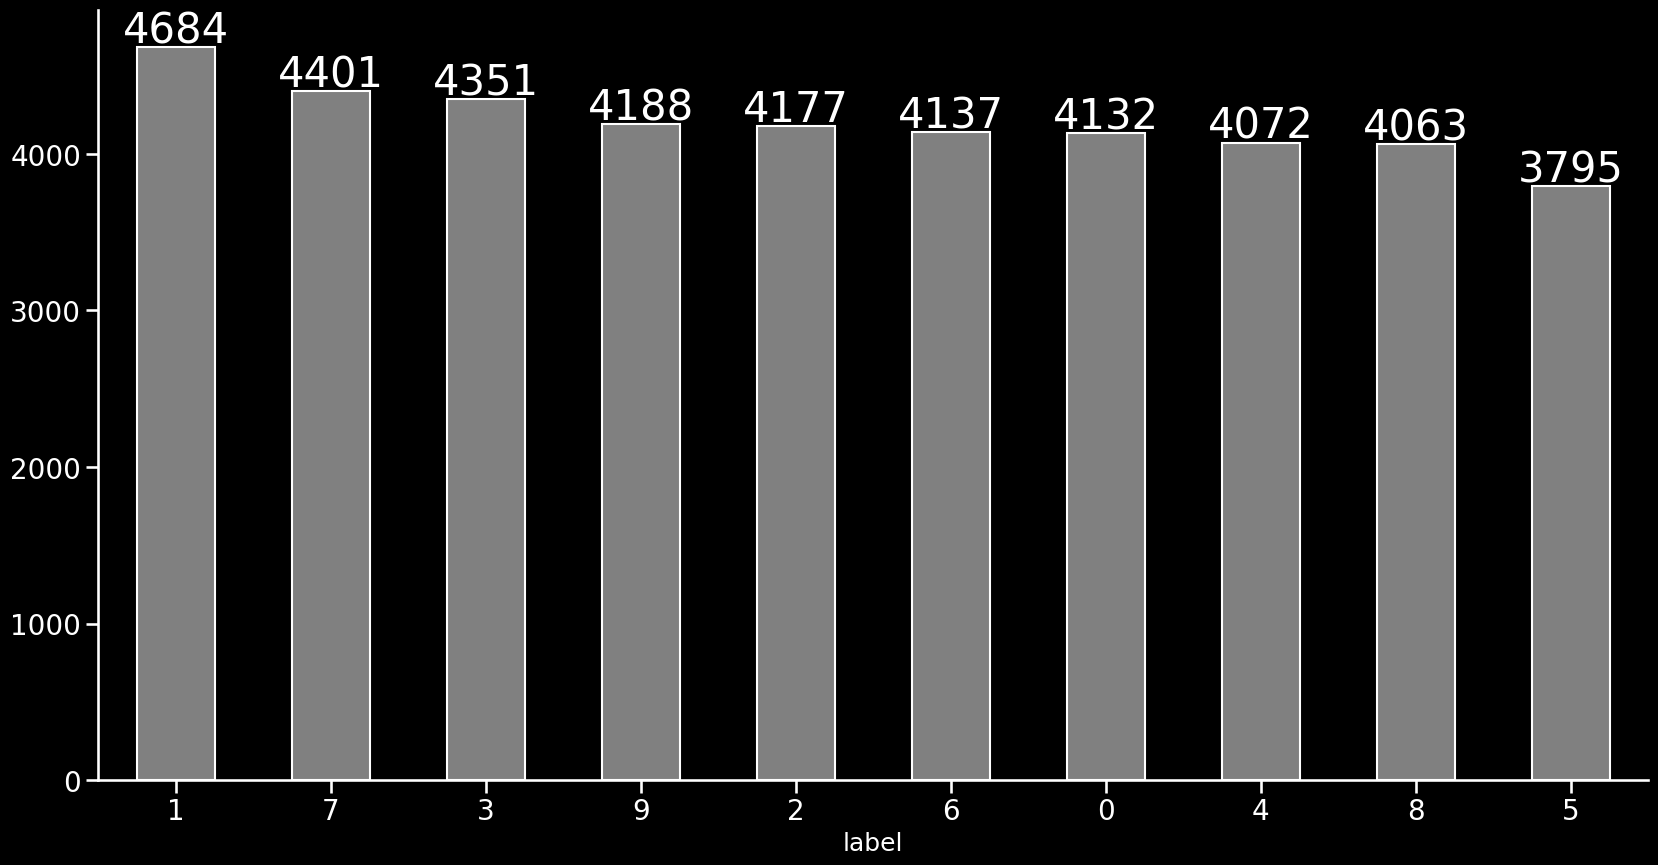

In [4]:
sns.set_theme(style="ticks", context="talk",font_scale = 1)
plt.style.use("dark_background")
plt.figure(figsize = (20,10))
ax = train_y.value_counts().sort_values(ascending=False).plot(kind='bar',
                                                                        grid = False,
                                                                        fontsize=20,
                                                                        color='grey')
plt.xticks(rotation=0)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 30, height, ha = 'center', size = 30)
sns.despine()

<span style="color:Blue"> **Observation**

* All numbers appear to be balanced.
* 1 is the most and 5 is the least.

<hr style="border: solid 3px blue;">

# Checking Anomaly

![](https://miro.medium.com/max/1400/1*Bl1pi1ZHwncJqiuugKYndQ.png)

Picture Credit: https://miro.medium.com

> In data analysis, anomaly detection (also referred to as outlier detection) is generally understood to be the identification of rare items, events or observations which deviate significantly from the majority of the data. Such examples may arouse suspicions of being generated by a different mechanism, or appear inconsistent with the data.

Ref: https://en.wikipedia.org/wiki/Anomaly_detection

Here, anomaly detection is performed and which records are determined as outliers. Then, draw these values as a picture, and visually check and understand outliers.

In [6]:
from pycaret.anomaly import *

In [7]:
pycaret.anomaly.setup(
    data=train_df,
    silent=True)

,Description,Value
0,session_id,5786
1,Original Data,"(42000, 785)"
2,Missing Values,False
3,Numeric Features,618
4,Categorical Features,167
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(42000, 1344)"
9,CPU Jobs,-1


(KFold(n_splits=10, random_state=None, shuffle=False),
 5,
 {'tsne': 'Anomaly TSnE (3d)', 'umap': 'UMAP Dimensionality'},
 'lightgbm',
 None,
 <MLUsecase.ANOMALY: 4>,
 False,
 None,
 10,
 False,
 -1,
 5786,
 '1b11',
 'lightgbm',
 False,
 'box-cox',
 Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False),
 'UNSUPERVISED_DUMMY_TARGET',
 False,
 [],
 True,
 [],
 {},
 None,
 [('Setup Config',
                                  Description                 Value
   0                               session_id                  5786
   1                            Original Data          (42000, 785)
   2                           Missing Values                 False
   3                         Numeric Features                   618
   4                     Categorical Features                   167
   5                         Ordinal Features                 False
   6                High Cardinality Features                 False
   7                  High Cardinality Meth

In [8]:
pca = pycaret.anomaly.create_model('pca')

In [9]:
plot_model(pca, plot = 'umap')

<span style="color:Blue"> **Observation**

* The yellow dots are outliers. There don't seem to be many outliers.

In [10]:
pca_df = pycaret.anomaly.assign_model(pca)

In [11]:
abnormal_data = pca_df[pca_df.Anomaly == 1].sort_values(by='Anomaly_Score', ascending=False)
print("the size of anomaly = ",len(abnormal_data))
abnormal_data.head(10).style.set_properties(**{'background-color': 'black',
                           'color': 'white',
                           'border-color': 'white'})

the size of anomaly =  2100


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

<span style="color:Blue"> **Observation**

* There are 2100 anomalies.
* In the last column, there is an anomaly score, so the degree of anomaly can be judged.   

**Let's check the top 10 out of the above outlier data.**

In [12]:
top10 = abnormal_data.drop('label',axis=1)[:10]
top10 = top10.loc[:,:'pixel783']

In [13]:
fig = plt.figure(figsize=(25, 4))
img = np.array(top10).reshape(-1, 28, 28)
fig = px.imshow(img,color_continuous_scale='Blues_r',facet_col=0, binary_string=True, facet_col_wrap=5,labels={'facet_col':'img'})
fig.show()

<Figure size 1800x288 with 0 Axes>

<span style="color:Blue"> **Observation**

* Among the outliers, there are pictures that are confusing even with our eyes when looking at the pictures drawn by selecting the top 10 by sorting based on the value of the largest abnormal score.

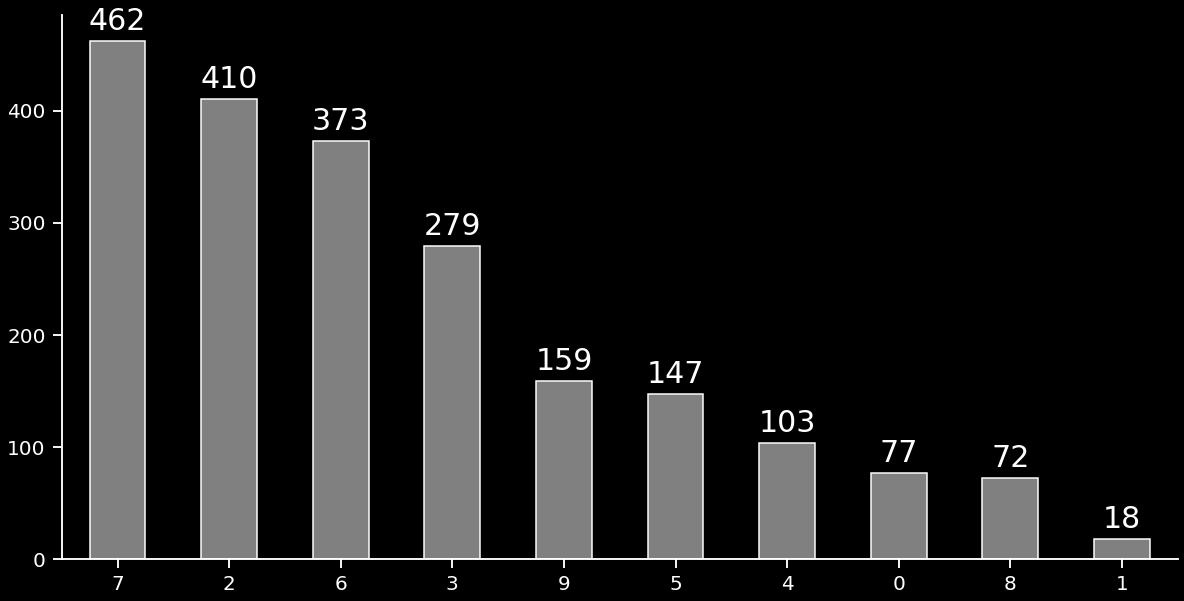

In [14]:
sns.set(style="ticks", context="talk",font_scale = 1)
plt.style.use("dark_background")
plt.figure(figsize = (20,10))
ax = abnormal_data.label.value_counts().sort_values(ascending=False).plot(kind='bar',
                                                                        grid = False,
                                                                        fontsize=20,
                                                                        color='grey')
plt.xticks(rotation=0)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 10, height, ha = 'center', size = 30)
sns.despine()

<span style="color:Blue"> **Observation**

* A lot of outliers are seen in the numbers 7, 2, and 6.
* Numbers of 1 seem to have the fewest outliers.

------------------------------------------------------------------------------------------
# Checking train dataset

Let's draw pictures by randomly picking 8 pieces of data.

In [15]:
fig = plt.figure(figsize=(25, 4))
img = np.array(train_x.sample(8)).reshape(-1, 28, 28)
fig = px.imshow(img,facet_col=0, binary_string=True, facet_col_wrap=4,labels={'facet_col':'img'})
fig.show()

<Figure size 1800x288 with 0 Axes>

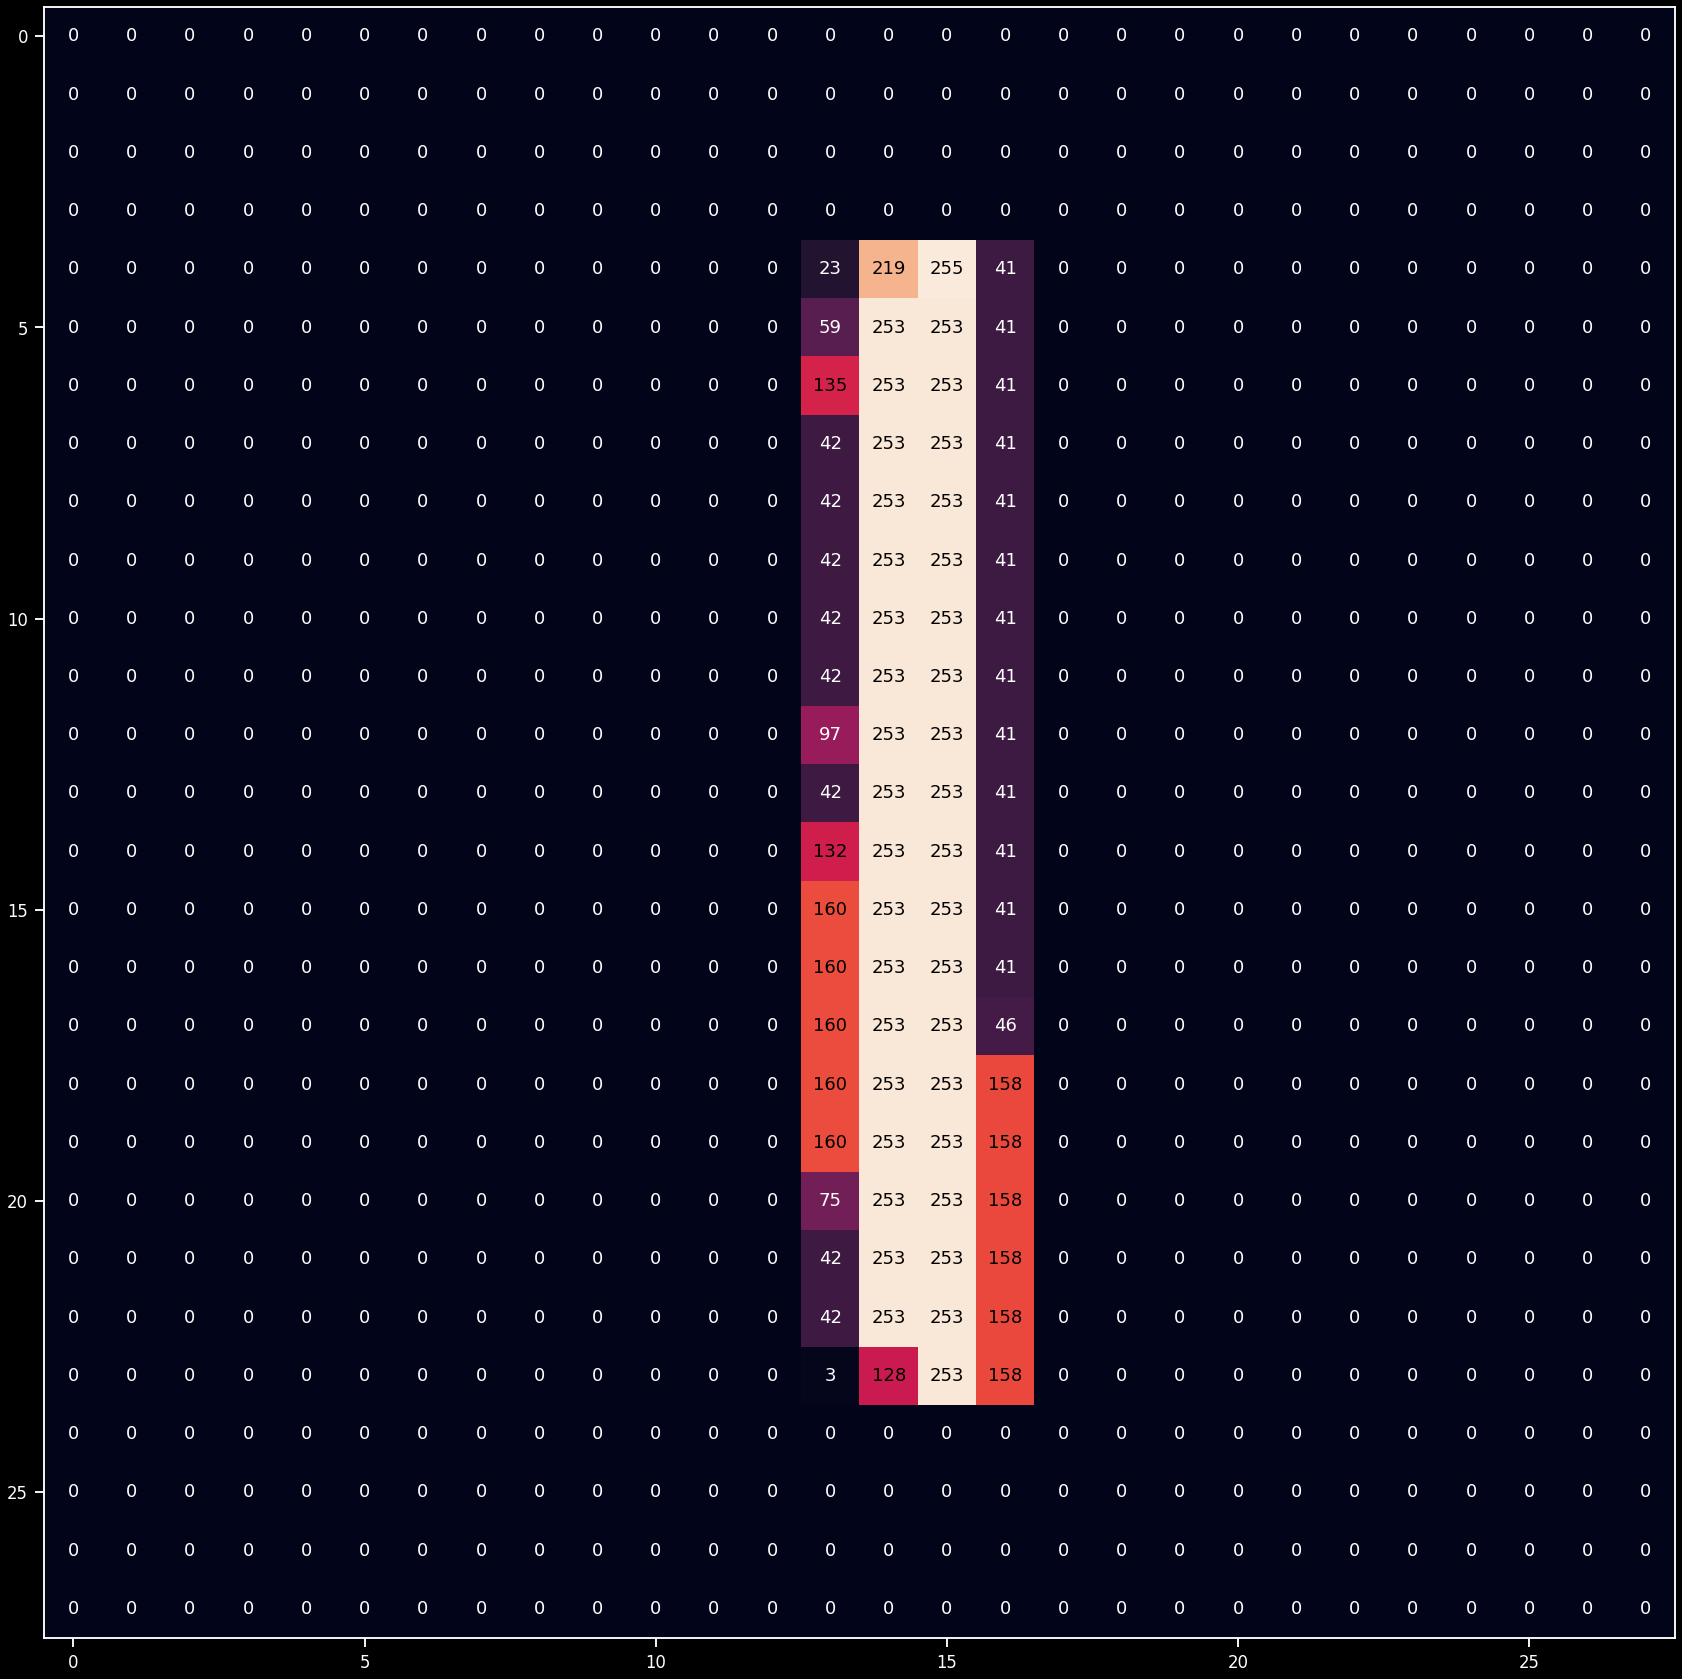

In [16]:
img = np.array(train_x.sample(1))[0].reshape( 28, 28)
sns.set(style="ticks", context="talk",font_scale = 1)
plt.style.use("dark_background")
fig = plt.figure(figsize = (30,30)) 
ax = fig.add_subplot(111)
ax.imshow(img)
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

<span style="color:Blue"> **Observation**
    
* Each number image in MNIST is only a list of 28 * 28 dimensional numbers.

In [17]:
print(train_x.shape)

sample_size = 5000

train_x = pd.DataFrame(train_x[:sample_size])
train_y = train_y[:sample_size]

(42000, 784)


<hr style="border: solid 3px blue;">

# Plotting after Dimensional Reduction

![](https://miro.medium.com/max/698/1*WVFe7w1rzZWsmghdvaoXag.png)

Picture Credit: https://miro.medium.com

We want to understand the characteristics of the dataset by projecting the dataset to a low dimension through PCA and UMAP.

-------------------------------------------------
## PCA

PCA is the most representative method of dimensionality reduction. This is a method of re-axis of multidimensional data in the direction of large variance. The greater the dependence between variables, the smaller the principal component can represent the original data. However, since it is assumed that each feature follows a normal distribution, it is not appropriate to apply a variable with a distorted distribution to PCA.

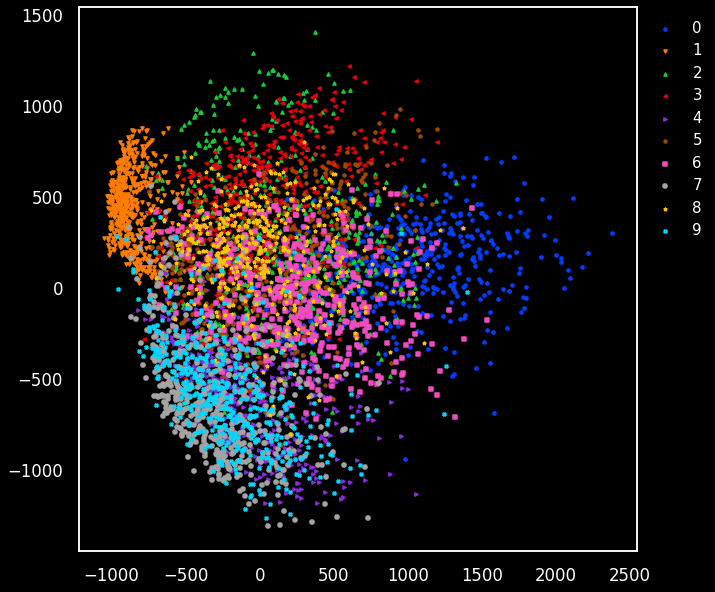

In [18]:
from sklearn.decomposition import PCA

pca = PCA()
x_pca = pca.fit_transform(train_x)
markers=['o','v','^','<','>','8','s','P','*','X']
# plot in 2D by class
sns.set(style="white", context="talk",font_scale = 1)
plt.style.use("dark_background")
sns.set_palette("bright")
plt.figure(figsize=(10,10))
for i,marker in enumerate(markers):
    mask = train_y == i
    plt.scatter(x_pca[mask, 0], x_pca[mask, 1], label=i, s=10, alpha=1,marker=marker)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)

-----------------------------------
## UMAP plot

> Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data
> 
> 1. The data is uniformly distributed on Riemannian manifold;
> 2. The Riemannian metric is locally constant (or can be approximated as such);
> 3. The manifold is locally connected.
> From these assumptions it is possible to model the manifold with a fuzzy topological structure. The embedding is found by searching for a low dimensional projection of the data that has the closest possible equivalent fuzzy topological structure.

Ref: https://umap-learn.readthedocs.io/en/latest/

<AxesSubplot:>

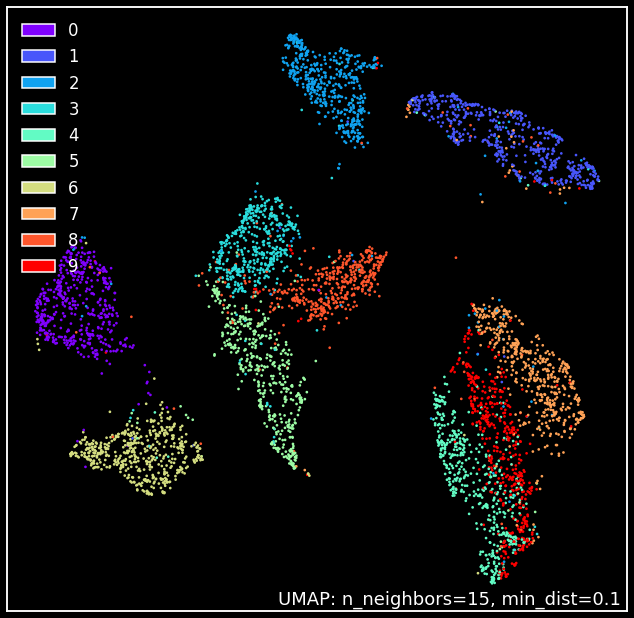

In [19]:
import umap.plot
mapper = umap.UMAP().fit(train_x)
umap.plot.points(mapper, labels=train_y, theme='fire')

It looks like an orderly universe. A few galaxies seem to be visible as well.

------------------------------------------------------------
# UMAP 3D plot

In [20]:
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(train_x)
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(train_y,name='label')
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='label', labels={'color': 'number'}
)
fig.update_traces(marker_size=1)
fig.show()

<class 'numpy.ndarray'>


<span style="color:Blue"> **Observation**
    
* When looking at the figures of dimensional reduction in the lower dimension, boundaries are visible even with our eyes. In other words, the reason why MNIST can get better results than other datasets is probably well-separated as in the above figures of the dataset.
    

<hr style="border: solid 3px blue;">

# Simple is better!

![](https://image.freepik.com/free-photo/simple-is-better_360032-968.jpg)

We create a model using class ML and try to understand the operation of this model. And, using pycaret, we tune the model design and hyperparameters with short code. After that, we will try to understand the behavior of these models with various visualizations.

A simple way to do the above operations is to use a well-made library. Using Pycaret is also a good option.

------------------------------------------
## Setting Up

> This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [21]:
from pycaret.classification import *
setup(data = train_df, 
             target = 'label',
             preprocess = False,
             silent=True)

,Description,Value
0,session_id,7452
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(42000, 785)"
5,Missing Values,False
6,Numeric Features,608
7,Categorical Features,176
8,Transformed Train Set,"(29399, 784)"
9,Transformed Test Set,"(12601, 784)"


(StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
 5,
 {'parameter': 'Hyperparameters',
  'auc': 'AUC',
  'confusion_matrix': 'Confusion Matrix',
  'threshold': 'Threshold',
  'pr': 'Precision Recall',
  'error': 'Prediction Error',
  'class_report': 'Class Report',
  'rfe': 'Feature Selection',
  'learning': 'Learning Curve',
  'manifold': 'Manifold Learning',
  'calibration': 'Calibration Curve',
  'vc': 'Validation Curve',
  'dimension': 'Dimensions',
  'feature': 'Feature Importance',
  'feature_all': 'Feature Importance (All)',
  'boundary': 'Decision Boundary',
  'lift': 'Lift Chart',
  'gain': 'Gain Chart',
  'tree': 'Decision Tree',
  'ks': 'KS Statistic Plot'},
 27081    7
 26213    3
 7363     0
 14904    5
 966      7
         ..
 33595    6
 6773     1
 7111     6
 4149     7
 29273    1
 Name: label, Length: 12601, dtype: int64,
 'lightgbm',
 None,
 <MLUsecase.CLASSIFICATION: 1>,
 False,
 None,
 10,
 False,
 -1,
 7452,
 'f177',
       pixel0 pixel1 pixel2 pi

--------------------------------------------
## Creating Model

> This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold.

https://pycaret.readthedocs.io/en/latest/api/classification.html

In [22]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9599,0.9986,0.9599,0.9599,0.9598,0.9554,0.9554
1,0.9602,0.9986,0.9597,0.9604,0.9602,0.9558,0.9558
2,0.9660,0.9987,0.9660,0.9663,0.9660,0.9622,0.9622
3,0.9626,0.9980,0.9622,0.9626,0.9626,0.9584,0.9584
4,0.9636,0.9990,0.9634,0.9638,0.9636,0.9595,0.9596
5,0.9701,0.9990,0.9700,0.9702,0.9700,0.9667,0.9668
6,0.9629,0.9985,0.9625,0.9629,0.9629,0.9588,0.9588
7,0.9639,0.9990,0.9636,0.9640,0.9639,0.9599,0.9599
8,0.9636,0.9984,0.9634,0.9638,0.9636,0.9595,0.9596
9,0.9677,0.9991,0.9672,0.9678,0.9676,0.9641,0.9641


In [23]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8466,0.9148,0.8447,0.8457,0.8459,0.8295,0.8295
1,0.8303,0.9057,0.8282,0.8297,0.8298,0.8113,0.8114
2,0.8568,0.9205,0.8555,0.8570,0.8566,0.8408,0.8409
3,0.8486,0.9160,0.8469,0.8486,0.8485,0.8317,0.8318
4,0.8463,0.9146,0.8442,0.8472,0.8465,0.8291,0.8291
5,0.8531,0.9184,0.8517,0.8531,0.8530,0.8367,0.8367
6,0.8415,0.9120,0.8396,0.8419,0.8416,0.8238,0.8238
7,0.8405,0.9114,0.8389,0.8406,0.8402,0.8227,0.8228
8,0.8531,0.9184,0.8507,0.8524,0.8525,0.8367,0.8367
9,0.8326,0.9071,0.8306,0.8324,0.8323,0.8139,0.8139


-------------------------------------
## Tuning Hyperparameters

> This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter. 

https://pycaret.readthedocs.io/en/latest/api/classification.html

In [24]:
tuned_et = tune_model(et, optimize = 'Accuracy',early_stopping = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9388,0.9953,0.9388,0.9388,0.9385,0.9319,0.9320
1,0.9316,0.9959,0.9311,0.9319,0.9315,0.9240,0.9241
2,0.9371,0.9962,0.9370,0.9373,0.9369,0.9301,0.9301
3,0.9313,0.9954,0.9307,0.9314,0.9312,0.9236,0.9237
4,0.9374,0.9968,0.9369,0.9374,0.9373,0.9304,0.9305
5,0.9476,0.9968,0.9475,0.9478,0.9475,0.9418,0.9418
6,0.9384,0.9958,0.9378,0.9384,0.9383,0.9316,0.9316
7,0.9395,0.9965,0.9388,0.9395,0.9393,0.9327,0.9327
8,0.9347,0.9953,0.9342,0.9352,0.9346,0.9274,0.9275
9,0.9388,0.9963,0.9379,0.9385,0.9385,0.9319,0.9319


In [25]:
params = { "max_depth":[2]}
tuned_dt = tune_model(dt, optimize = 'Accuracy',early_stopping = True,custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.3340,0.7540,0.3185,0.1607,0.2107,0.2556,0.2843
1,0.3378,0.7589,0.3222,0.1662,0.2149,0.2598,0.2899
2,0.3340,0.7549,0.3187,0.1646,0.2131,0.2557,0.2854
3,0.3425,0.7556,0.3268,0.1701,0.2189,0.2652,0.2962
4,0.3378,0.7545,0.3222,0.1643,0.2137,0.2599,0.2898
5,0.3350,0.7541,0.3197,0.1642,0.2129,0.2569,0.2865
6,0.3435,0.7523,0.3281,0.1662,0.2173,0.2664,0.2964
7,0.3412,0.7543,0.3259,0.1669,0.2170,0.2638,0.2938
8,0.3432,0.7592,0.3276,0.1697,0.2197,0.2660,0.2966
9,0.3331,0.7509,0.3180,0.1625,0.2120,0.2546,0.2832


-------------------------------
## Interpreting Modeling

> This function analyzes the predictions generated from a trained model. Most plots in this function are implemented based on the SHAP (SHapley Additive exPlanations)

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Pr

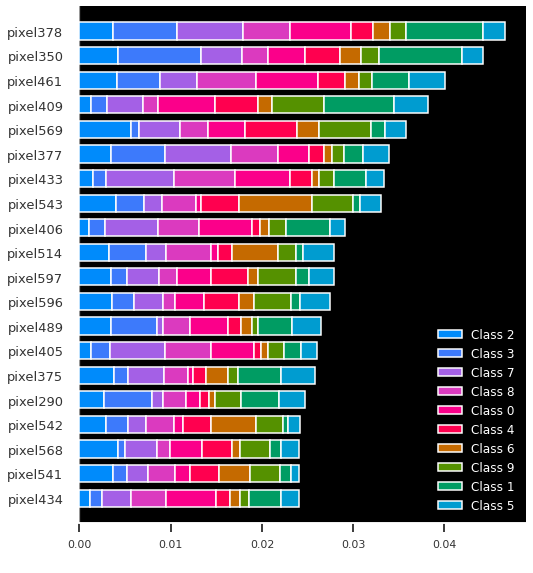

In [26]:
with plt.rc_context({'figure.facecolor':'white'}):
    interpret_model(tuned_et)

<span style="color:Blue"> **Observation**

* Pixel 378 was determined as important features from the model point of view.
* Each class has different feature importance.  

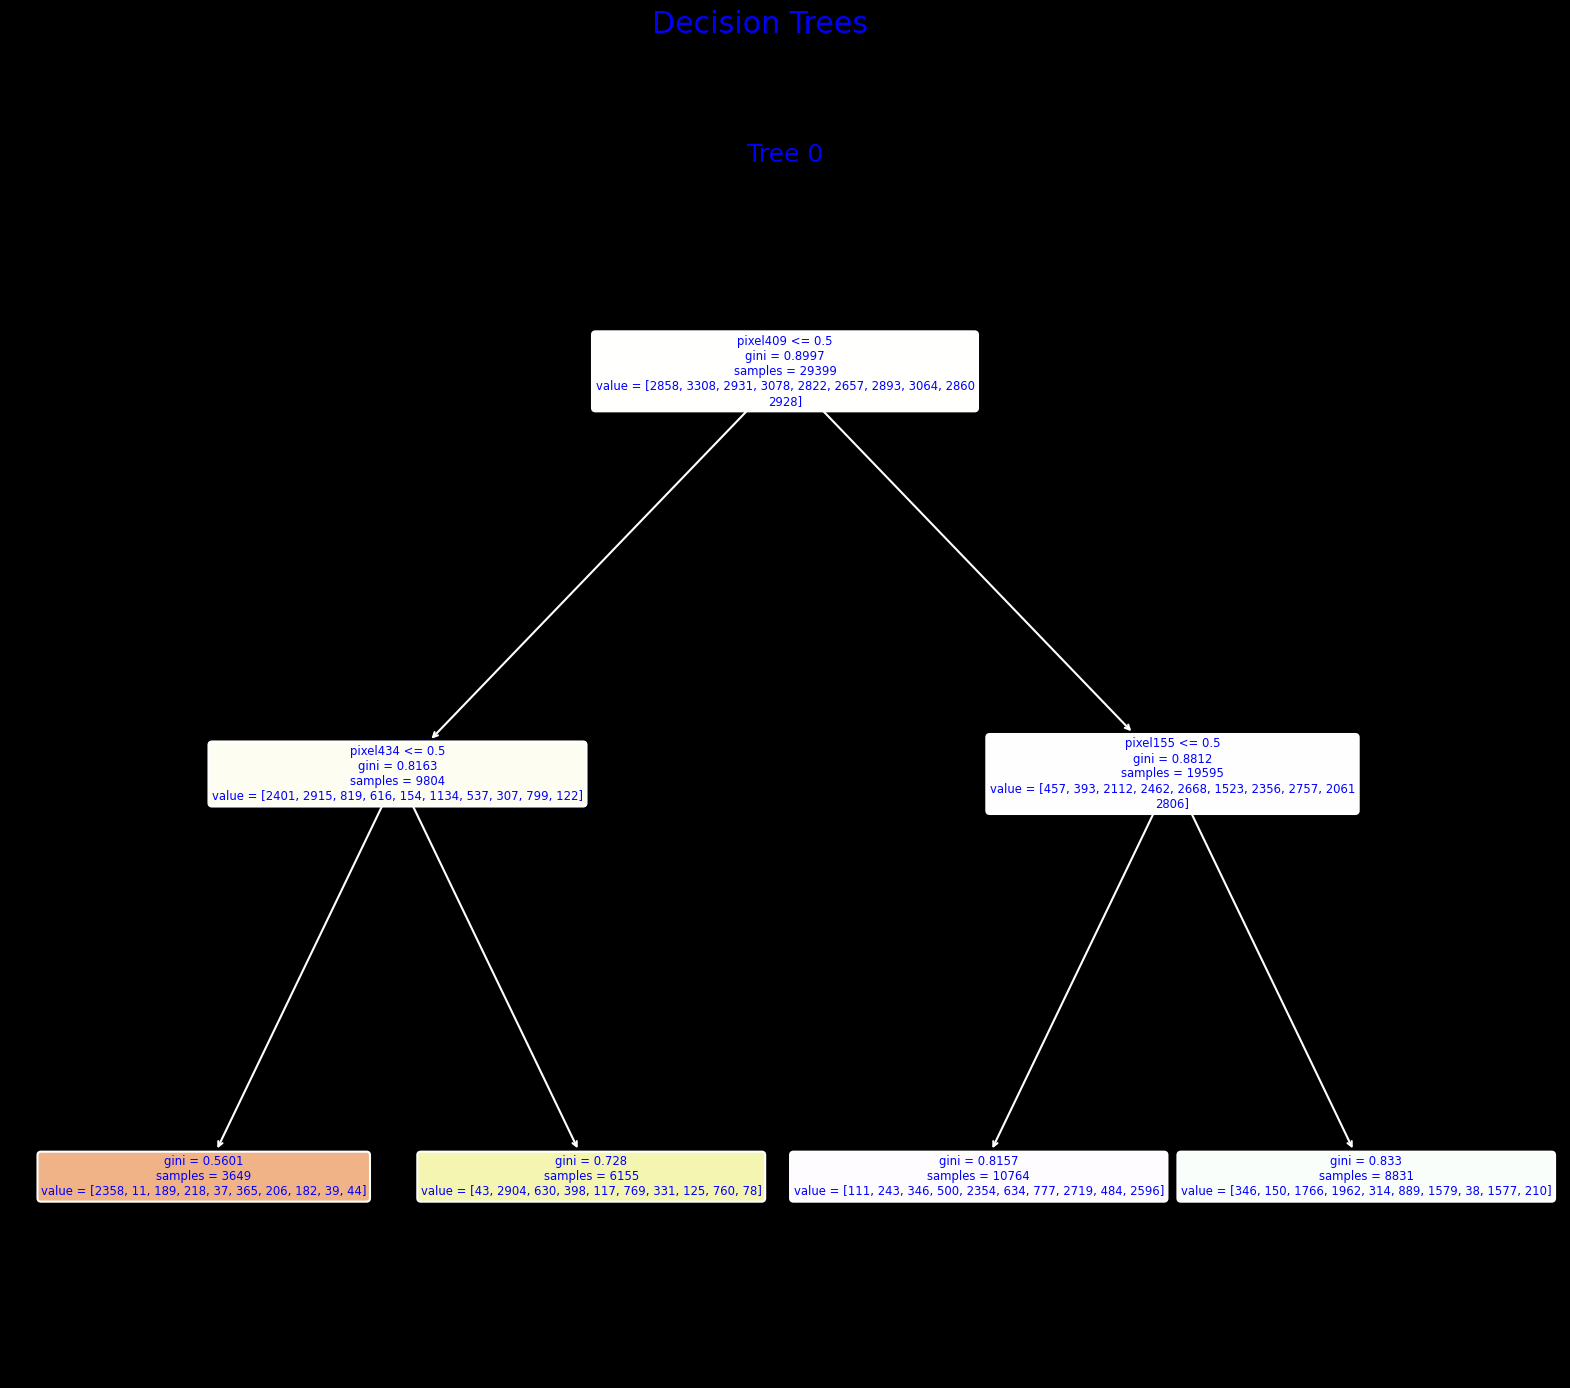

In [27]:
with plt.rc_context({'figure.facecolor':'black','text.color':'blue'}):
    plot_model(tuned_dt, plot='tree')

Decision tree is one of the most basic ML methods. The above figure is a simplified drawing to check how the decision tree model makes a decision on the MNIST dataset.

If you look at the picture above, you can check how the class is separated according to the value of each pixel.

--------------------------------
## Calibrating Model

> This function calibrates the probability of a given estimator using isotonic or logistic regression.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.

In [28]:
cali_model = calibrate_model(tuned_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9391,0.9964,0.9391,0.9392,0.9390,0.9323,0.9324
1,0.9378,0.9969,0.9373,0.9379,0.9377,0.9308,0.9309
2,0.9429,0.9969,0.9431,0.9428,0.9427,0.9365,0.9365
3,0.9347,0.9964,0.9342,0.9348,0.9346,0.9274,0.9274
4,0.9415,0.9976,0.9412,0.9417,0.9414,0.9350,0.9350
5,0.9480,0.9977,0.9482,0.9480,0.9479,0.9422,0.9422
6,0.9415,0.9966,0.9411,0.9415,0.9414,0.9350,0.9350
7,0.9412,0.9973,0.9408,0.9413,0.9411,0.9346,0.9346
8,0.9354,0.9963,0.9350,0.9355,0.9352,0.9282,0.9282
9,0.9415,0.9971,0.9409,0.9413,0.9414,0.9349,0.9350


------------------------------------
## Finalizing Mode

> This function trains a given estimator on the entire dataset including the holdout set.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [29]:
final_model = finalize_model(cali_model)

---------------------------------------------------
## Plotting using the final model

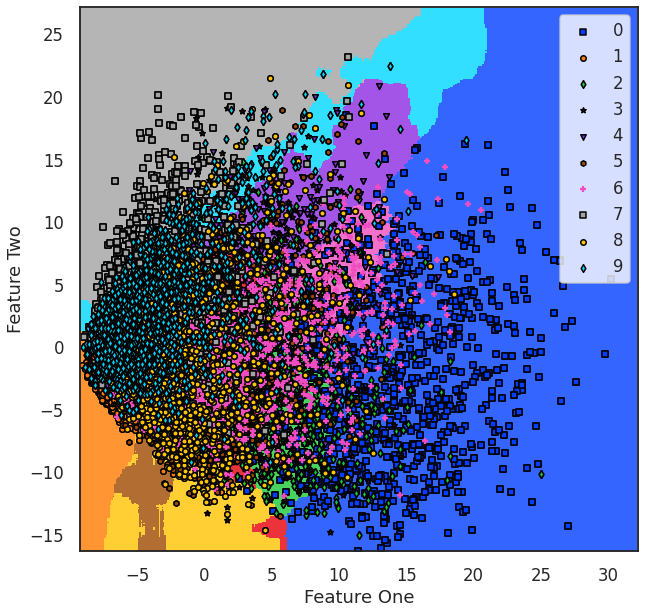

In [30]:
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(10, 10))
with plt.rc_context({'figure.facecolor':'grey'}):
    plot_model(final_model, plot='boundary')

<span style="color:Blue"> **Observation**

* If you look at the picture above, you can see that the boundaries are determined for each class by reducing it to two dimensions.
* It seems that the boundaries for most classes are well determined.
* In the areas where data overlapped in the middle of the left, the boundaries were complicatedly determined.
* Even though the 784 dimension is reduced to 2D, the boundary is well determined, so a more detailed boundary can be drawn in the 784 dimension. However, we can neither draw nor understand 784-dimensional pictures.
    


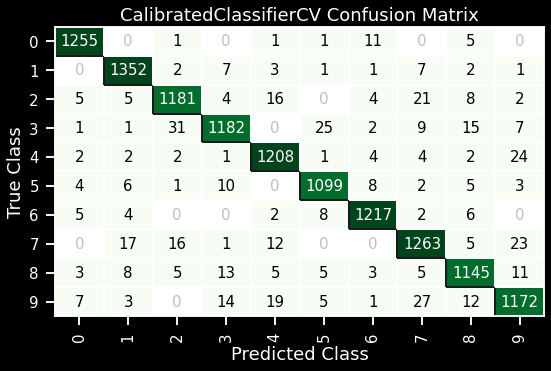

In [31]:
sns.set(style="ticks", context="talk",font_scale = 1)
plt.style.use("dark_background")
plot_model(final_model, plot='confusion_matrix')

<span style="color:Blue"> **Observation**

* There are cases in which data related to Class 9 is incorrectly judged as 4 or 7. Looking at the shape of 9, there seems to be a possibility that it may be wrongly judged.
* There are cases where data related to Class 1 are incorrectly judged as 2 or 8. 

--------------------------------------------
## Predicting using the final model

In [32]:
pred_unseen = predict_model(final_model, data = test_df)

In [33]:
submission_df['Label'] = pred_unseen['Label']
submission_df.to_csv('submission.csv',header =  ['ImageId', 'Label' ], index = None)